In [ ]:
from typing import Callable
import matplotlib
import matplotlib.pyplot as plt
import tinygrad as tg
import numpy as np
#matplotlib.use('MacOSX')  # Replace 'TkAgg' with your preferred backend

# The goal is to express all polynomials with a neural network that only uses relu activation functions
# many thanks to Nikolaj-K @ https://www.youtube.com/watch?v=PApGm1TKFHQ for the topic
# rewrote it in a different way

# Utils


In [13]:
def plot(x: np.ndarray) -> Callable[[np.ndarray,str,str], None]:
    """
    Curries X into the plot function
    """
    def fn(y: np.ndarray, label: str, color: str) -> None:
        plt.plot(x, y, label=label, color=color)
    return lambda y,label,color : fn(y,label,color)


def plt_setup() -> None:
    plt.grid(True)
    plt.style.use('dark_background')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.title("getting $a*(X^2)+b$ from Relus is the goal")
    plt.style.use('dark_background')
    return None

color_cycle = matplotlib.colormaps["Spectral"]


# STEP 1 : get X^2 from adding piecewise linear functions (triangle wave functions)

In [81]:
def triangle_wave(x: tg.Tensor) -> tg.Tensor:
    left = x-x.floor()
    right = x.ceil()-x
    return (left<right)*left +(left>=right)*right

def takagi(x: tg.Tensor, N:int) ->  tg.Tensor:
    #https://en.wikipedia.org/wiki/Blancmange_curve
    return tg.Tensor.stack([takagi_piece(x,i) for i in range(N)],dim=1).sum(axis=1)

def takagi_piece(x: tg.Tensor, i: int) -> tg.Tensor:
    w = 0.25 # w=1/4 gives the parabola !
    return (w**i) * triangle_wave((2**i)*x)

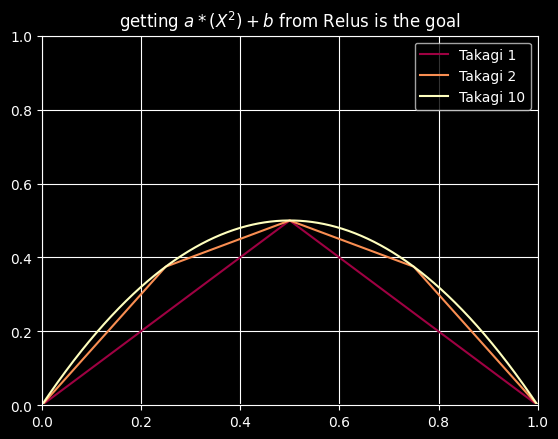

In [83]:
color_cycle = matplotlib.colormaps["Spectral"]
X=tg.Tensor.arange(0,1,0.001)
prt = plot(X.numpy())
prt(takagi(X,1).numpy(), "Takagi 1", color=color_cycle(0.0))
prt(takagi(X,2).numpy(), "Takagi 2", color=color_cycle(0.25))
prt(takagi(X,10).numpy(), "Takagi 10", color=color_cycle(0.5))
plt_setup()
plt.show()

# Step 2 : get the triangle wave functions from Relus

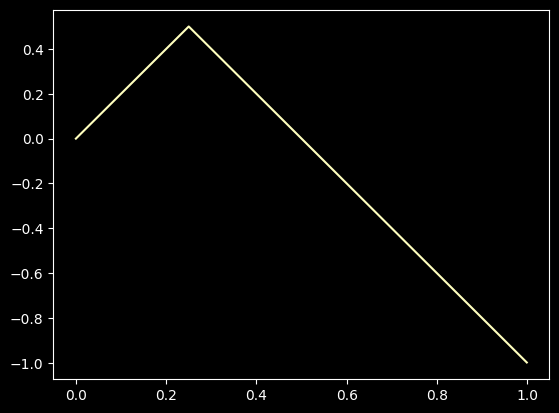

In [86]:
def relu(x: tg.tensor.Tensor) -> tg.tensor.Tensor:
    return x.relu()

def triangle_1(x: tg.tensor.Tensor) -> tg.tensor.Tensor:
    return relu(x)-2*relu(x-0.5)

def triangle_2(x: tg.tensor.Tensor) -> tg.tensor.Tensor:
    return triangle_1(2*X)+relu2

X = tg.Tensor.arange(0,1,0.001)
prt = plot(X.numpy())
prt(triangle_2(X).numpy(), "tinygrad tensor", color=color_cycle(0.5))

In [58]:
X.numpy()

array([0.        , 0.001     , 0.002     , 0.003     , 0.004     ,
       0.005     , 0.006     , 0.007     , 0.008     , 0.009     ,
       0.01      , 0.011     , 0.012     , 0.013     , 0.014     ,
       0.015     , 0.016     , 0.017     , 0.018     , 0.019     ,
       0.02      , 0.021     , 0.022     , 0.023     , 0.024     ,
       0.025     , 0.026     , 0.027     , 0.028     , 0.029     ,
       0.03      , 0.031     , 0.032     , 0.033     , 0.03400001,
       0.035     , 0.036     , 0.037     , 0.03800001, 0.039     ,
       0.04      , 0.041     , 0.04200001, 0.043     , 0.044     ,
       0.04500001, 0.04600001, 0.047     , 0.048     , 0.04900001,
       0.05000001, 0.051     , 0.052     , 0.05300001, 0.05400001,
       0.055     , 0.05600001, 0.05700001, 0.05800001, 0.059     ,
       0.06000001, 0.06100001, 0.06200001, 0.063     , 0.064     ,
       0.06500001, 0.06600001, 0.067     , 0.068     , 0.06900001,
       0.07000001, 0.071     , 0.072     , 0.07300001, 0.07400

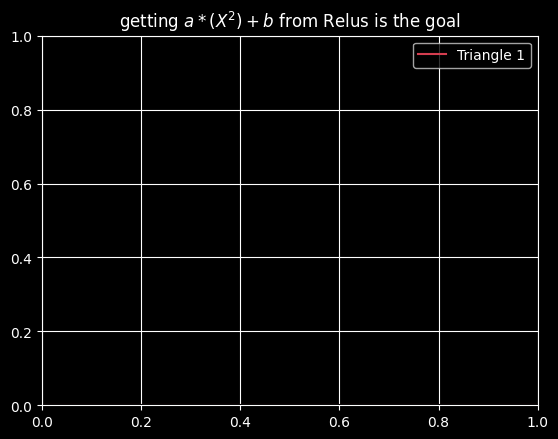

In [30]:
color_cycle = matplotlib.colormaps["Spectral"]
X = np.linspace(0, 1., 100)
prt = plot(X)
prt(np.vectorize(triangle_1)(X), "Triangle 1", color=color_cycle(0.1))
#for i in [0,1,2,3]:
#    prt(np.vectorize(relu_piece(i))(X), f"Relu piece {i}", color=color_cycle(0.1*i))
plt_setup()
plt.show()